In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

import statsmodels
import random
import torch

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

from sklearn.metrics import roc_curve, auc
from joblib import Parallel, delayed
import pybedtools
from tqdm import tqdm

/tmp/ipykernel_1874700/1954166253.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
metadata = pd.read_csv("./all.metadata.tsv", sep="\t",header=None)
metadata.columns = ["cellname", "celltype","mc_id","mc_20","mc_25"]
# majority voting for each mc_id, determine the celltype
metadata_mc = metadata.groupby("mc_id")["celltype"].agg(lambda x: x.mode()[0]).reset_index()

rnamat = pd.read_csv("SCT_metacellmean.tsv.gz",sep="\t",index_col=0)
rnamat.index.name = "mc_id"
variable_genes = pd.read_csv("./all.top5k.variablegenes.tsv",header=None).values.T.astype(str)[0]

In [3]:
genes = pd.read_csv("./transcripts.bed",sep="\t",header=None)
genes.columns = ["chrom","start","end","name","strand"]
genes["start"] = genes["start"] // 5000 * 5000
genes["end"] = genes["end"] // 5000 * 5000 + 5000


In [4]:
tss = pd.read_csv("./tss.bed",sep="\t",header=None)
tss.columns = ["chrom","start","end","gene","strand"]
tss["genome_coord"] =  tss.apply(lambda x: f"{x['chrom']}:{x['start']//5000*5000-int(2e6)}-{x['start']//5000*5000+5000+int(2e6)}", axis=1)
tss = tss.query('chrom != "chrM"')[["gene","genome_coord"]].drop_duplicates().reset_index(drop=True)
tss["tss_id"] = tss["gene"] + "_" + (tss.groupby("gene").cumcount() + 1).astype(str)

In [5]:
considered_genes = pd.read_table("./groud_truth/considered_genes.txt", header=None).values.T.astype(str)[0]
tss.query('gene in @considered_genes', inplace=True)

In [6]:
#filepaths = glob.glob("./corres/*.tsv.gz")
filepaths = [f"corres/{gene}_1.tsv.gz" for gene in considered_genes]
tss_ids = [x.split("/")[-1].split(".")[0] for x in filepaths]

In [7]:
def _read_corres(filepath,tss_id):
    gene,genome_coord,tss_id = tss.query('tss_id == @tss_id')[["gene","genome_coord","tss_id"]].values[0]
    chrom,start_end = genome_coord.split(":")
    start,end = start_end.split("-")
    start,end = int(start),int(end)
    tss_bin = start + 2e6

    data = pd.read_csv(filepath,sep="\t")
    # if distance < 5, atac_neg10fdr > 2 & obsexp_distance_neg10fdr < -2 than significant
    data["distance_to_tss"] = np.arange(-2e6,2e6+5000,5000)
    data["chrom"] = chrom
    data["pos"] = start + data["distance_to_tss"] + 2e6
    data["pos"] = data["pos"].astype(int)
    data["tss_id"] = tss_id
    return data

In [8]:
dfs = []
for x,tss_id in tqdm(zip(filepaths,tss_ids)):
    try:
        dfs.append(_read_corres(x,tss_id))
    except:
        pass

162it [00:00, 179.61it/s]


In [9]:
data = pd.concat(dfs)
data["gene"] = data["tss_id"].str.split("_").str[0] 
print("Total tested pairs: ",data.shape[0])

Total tested pairs:  129762


In [10]:
pd.set_option('display.max_columns', None)

data = data.merge(genes[["name","start","end"]],left_on="gene",right_on="name",how="left")
data["within_gene"] = data.apply(lambda x: x["pos"] > (x["start"]+5000) and x["pos"] < (x["end"]-5000),axis=1) 
data_filter_distance = data.query('distance_highexp < 5 or within_gene')
data_filter_distance = data_filter_distance.fillna(0)
print("Total tested pairs: ",data_filter_distance.shape[0])

Total tested pairs:  22089


In [11]:
from statsmodels.stats.multitest import fdrcorrection

In [12]:
data_filter_distance["obsexp_distance_fdr"] = fdrcorrection(data_filter_distance["obsexp_distance_pval"])[1]
data_filter_distance["atac_fdr"] = fdrcorrection(data_filter_distance["atac_pval"])[1]
data_filter_distance["ct_fdr"] = fdrcorrection(data_filter_distance["ct_pval"])[1]
data_filter_distance["distance_fdr"] = fdrcorrection(data_filter_distance["distance_pval"])[1]

data_filter_distance["atac_neg10fdr"] = -np.log10(data_filter_distance["atac_fdr"])
data_filter_distance["obsexp_distance_neg10fdr"] = -np.log10(data_filter_distance["obsexp_distance_fdr"])
data_filter_distance["ct_neg10fdr"] = -np.log10(data_filter_distance["ct_fdr"])
data_filter_distance["distance_neg10fdr"] = -np.log10(data_filter_distance["distance_fdr"])


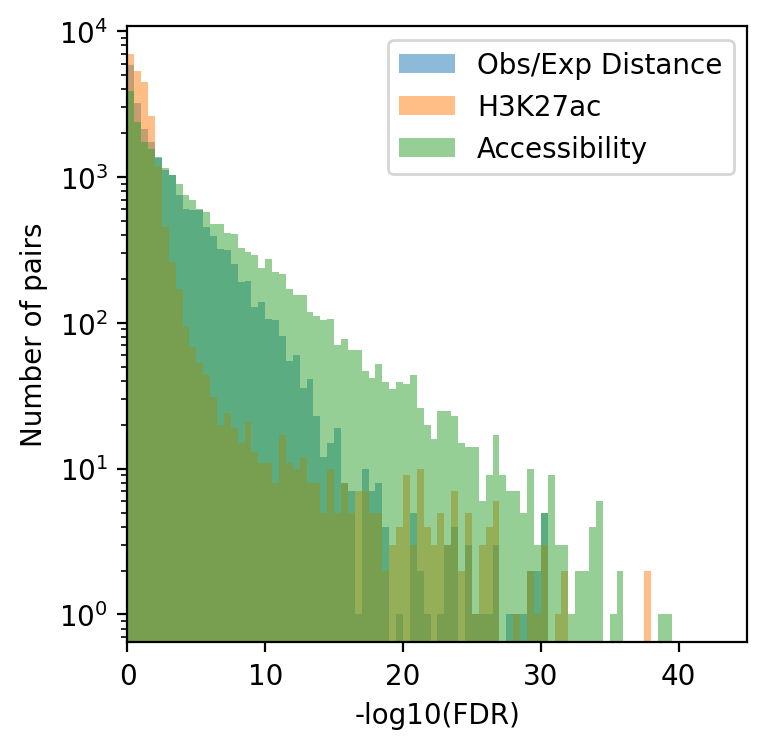

In [13]:
fig = plt.figure(figsize=(4,4))

plt.hist(data_filter_distance["obsexp_distance_neg10fdr"].values,label="Obs/Exp Distance",alpha=0.5,bins = np.arange(0,50,0.5))
plt.hist(data_filter_distance["ct_neg10fdr"].values,label="H3K27ac",alpha=0.5,bins = np.arange(0,50,0.5))
plt.hist(data_filter_distance["atac_neg10fdr"].values,label="Accessibility",alpha=0.5,bins = np.arange(0,50,0.5))

plt.yscale("log")
plt.legend()

plt.xlabel("-log10(FDR)")
plt.ylabel("Number of pairs")

plt.xlim(0,45)
plt.show()

In [14]:
# score based on correlation 
data_filter_distance["ct_neg10fdr"] = data_filter_distance["ct_neg10fdr"].clip(lower=0)
data_filter_distance["atac_neg10fdr"] = data_filter_distance["atac_neg10fdr"].clip(lower=0)
data_filter_distance["obsexp_distance_neg10fdr"] = data_filter_distance["obsexp_distance_neg10fdr"].clip(lower=0)
data_filter_distance = data_filter_distance.reset_index(drop=True)

def safe_pow(base, exponent):
    """处理基数为0且指数为负数的情况,避免除以零错误"""
    return np.where((exponent == -1) & (base == 0), 0, np.power(base, exponent))
    
data_filter_distance["score"] = (safe_pow(data_filter_distance["ct_neg10fdr"]+1,np.sign(data_filter_distance["ct_corr"])) * safe_pow(data_filter_distance["atac_neg10fdr"]+1,np.sign(data_filter_distance["atac_corr"]))) * np.maximum(1,safe_pow(data_filter_distance["obsexp_distance_neg10fdr"]+1,-np.sign(data_filter_distance["obsexp_distance_corr"])))
data_filter_distance["score"] = data_filter_distance["score"] / data_filter_distance.groupby("tss_id")["score"].transform("sum")

## Validation on mESC

In [15]:
data = pd.read_table("./groud_truth/groud_truth_considered.txt",header=None)
data.columns = ["chrom","start","end","gene","significant","ref"]
data["label"] = (data["significant"] == True).astype(int)

# I cant find the originnal Moorthy2016 paper, so it is not included in the analysis 
data = data.query('ref != "Moorthy2016"')

In [16]:
data.to_csv("./groud_truth/CHARM_used_groundtruth_raw.tsv",sep="\t",index=None)

In [17]:
# this is a bin/distance based abc score, same nature but different implementation
def compute_abc_score(row):
    try:
        gene = row["gene"]
        concat_df_mean = pd.read_csv(f"./data/{gene}.tsv.gz", sep="\t")
        concat_df_mean = concat_df_mean.query('cellname.str.startswith("P")', engine='python').\
            drop(columns=["cellname"]).\
            groupby(["chrom", "pos"]).mean()
        concat_df_mean["ABC"] = concat_df_mean["atac"] * concat_df_mean["ct"] / (concat_df_mean["distance"] + 0.1)
        chrom = row["chrom"]
        start = row["start"] // 5000 * 5000
        end = (row["end"] -1) // 5000 * 5000 + 5000
        pos = np.arange(start, end, 5000)
        return np.max(concat_df_mean.loc[(chrom, pos), "ABC"])

    except Exception as e:
        print(f"Error processing gene {row['gene']}: {e}")
        return np.nan

def _merge_rows(df):
    gene = df["gene"].values[0]
    label = df["label"].values[0]
    df_bed = pybedtools.BedTool.from_dataframe(df)
    df_bed_merged = df_bed.sort().merge().to_dataframe()
    df_bed_merged["gene"] = gene
    df_bed_merged["label"] = label
    return df_bed_merged

roc_data = data.copy()
roc_data = roc_data.groupby(["gene","label"]).apply(_merge_rows).reset_index(drop=True)
roc_data["ABC_predict"] = Parallel(n_jobs=50)(delayed(compute_abc_score)(row[1]) for row in tqdm(roc_data.iterrows()))
roc_data

180it [00:06, 25.75it/s]


,chrom,start,end,gene,label,ABC_predict
0,chr11,80080592,80081203,5730455P16Rik,0,0.005309
1,chr7,3199611,3215602,AU018091,1,0.120053
2,chr2,158361454,158361730,Actr5,0,0.008938
3,chr11,80080592,80081203,Adap2,0,0.008340
4,chr4,132345305,132346152,Ahdc1,0,0.005032
...,...,...,...,...,...,...
175,chr7,13014129,13014837,Zfp446,1,0.121810
176,chr7,13014129,13014837,Zfp606,0,0.046917
177,chr8,72330000,72335000,Zfp961,0,0.036679
178,chr7,13014129,13014837,Zscan18,0,0.063300


In [18]:
# find rows in roc_data if it is located in other gene's promoter 
roc_data_bed = pybedtools.BedTool.from_dataframe(roc_data[["chrom", "start", "end"]])
tss_temp = pd.read_csv("./tss.bed",sep="\t",header=None)
tss_temp.columns = ["chrom","start","end","gene","strand"]
tss_temp["start"] = tss_temp["start"] - 2500
tss_temp["end"] = tss_temp["end"] + 2500
tss_temp = tss_temp.query('chrom != "chrM" & start > 0')

tss_temp = pybedtools.BedTool.from_dataframe(tss_temp[["chrom", "start", "end"]])

roc_data_bed_intersect = roc_data_bed.intersect(tss_temp, u=True).to_dataframe()
roc_data_bed_intersect["locate_in_promoter"] = True

roc_data = roc_data.merge(roc_data_bed_intersect.drop_duplicates(),
                on=["chrom", "start", "end"],how="left")
roc_data["locate_in_promoter"] = roc_data["locate_in_promoter"].fillna(False)

In [19]:
# load ABC.score based on Fulco's code https://github.com/broadinstitute/ABC-Enhancer-Gene-Prediction

abc_peak = pd.read_table("/zliu_ssd/CHARM/CHARM_brain/4_cregene/metacell_allcells/ABC_score/ABC-Enhancer-Gene-Prediction/results/mESC/Predictions/EnhancerPredictions_threshold0.025_self_promoter.tsv")
#abc_peak = pd.read_table("/shared/mwang/CHARM-seq/ABC-Enhancer-Gene-Prediction/workflow/results/charm/Predictions/EnhancerPredictions_threshold0.025_self_promoter.tsv")
abc_peak = abc_peak.rename(columns={"chr":"chrom","TargetGene":"gene"})
abc_peak["pos"] = (abc_peak["start"] + abc_peak["end"]) // 2 //5000 * 5000

abc_peak = abc_peak.groupby(["chrom","pos","gene"])[["ABC.Score"]].sum().reset_index()

abc_inhouse = roc_data[["chrom","start","end","label","ABC_predict","gene"]]
abc_inhouse["pos"] = (abc_inhouse["start"] + abc_inhouse["end"]) // 2 // 5000 * 5000

compare_df = abc_inhouse.merge(abc_peak,how="left").merge(data_filter_distance[["chrom","pos","gene","score"]],how="left")
compare_df.columns = ["chrom","start","end","label","ABC_inhouse","gene","pos","ABC_score","Corr_score"]
# na to 0
compare_df["ABC_score"] = compare_df["ABC_score"].fillna(0)
compare_df["Corr_score"] = compare_df["Corr_score"].fillna(0)

## GLM regression

In [20]:
import sys
sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
import CHARMtools
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D
from sklearn.cluster import KMeans
from CHARMtools import regression
import pickle

In [21]:
metadata = pd.read_csv("./all.metadata.tsv",sep="\t",header = None)
metadata.columns = ["cellname","celltype","mc_15","mc_20","mc_30"]

with open("brain.pkl", "rb") as f:
    brain = pickle.load(f)
cells = list(brain.cells_dict.values())

In [22]:
rnamat = pd.read_csv("./all.rna.tsv.gz",sep="\t").set_index("gene")
rnamat = rnamat.div(rnamat.sum(axis=0), axis=1) * 1e4
rnamat = np.log2(rnamat + 1)

In [23]:
def _load_regression_data(gene):
    bins_considered = data_filter_distance.query('gene == @gene').query('obsexp_distance_fdr < 0.05 or atac_fdr < 0.05 or ct_fdr < 0.05')[["chrom","pos"]].copy().reset_index(drop=True)

    concat_df_mean = pd.read_csv(f"./data/{gene}.tsv.gz",sep="\t")

    atac_matrix = concat_df_mean[['chrom','pos','cellname','atac']].pivot_table(index=['chrom','pos'],columns='cellname',values='atac').fillna(0)
    ct_matrix = concat_df_mean[['chrom','pos','cellname','ct']].pivot_table(index=['chrom','pos'],columns='cellname',values='ct').fillna(0)
    obsexp_contact_matrix = concat_df_mean[['chrom','pos','cellname','obsexp_contact']].pivot_table(index=['chrom','pos'],columns='cellname',values='obsexp_contact').fillna(0)

    atac_matrix = atac_matrix.loc[bins_considered.set_index(["chrom","pos"]).index,metadata["cellname"].values]
    ct_matrix = ct_matrix.loc[bins_considered.set_index(["chrom","pos"]).index,metadata["cellname"].values]
    obsexp_contact_matrix = obsexp_contact_matrix.loc[bins_considered.set_index(["chrom","pos"]).index,metadata["cellname"].values]

    atac_matrix_norm = atac_matrix #* metadata["atac_FRIP"].values 
    ct_matrix_norm = ct_matrix #* metadata["ct_FRIP"].values 

    # minmax normalization on each row
    atac_matrix_norm = atac_matrix_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    ct_matrix_norm = ct_matrix_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    obsexp_contact_matrix_norm = obsexp_contact_matrix.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

    # na to 0
    atac_matrix_norm = atac_matrix_norm.fillna(0)
    ct_matrix_norm = ct_matrix_norm.fillna(0)
    obsexp_contact_matrix_norm = obsexp_contact_matrix_norm.fillna(0)

    atac_features = atac_matrix_norm.T   
    ct_features = ct_matrix_norm.T   
    contact_features = obsexp_contact_matrix_norm.T  
    X = np.hstack([atac_features, ct_features, contact_features])
    y = rnamat.loc[gene, metadata["cellname"].values].values
    y = (y - np.min(y)) / (np.max(y) - np.min(y)) * 100

    return X, y, bins_considered

In [24]:
import CHARMtools

In [26]:
# rerun this cell if picklable problem occurs
def compute_shap(row):
    gene = row["gene"]
    start = row["start"] // 5000 * 5000
    end =   (row["end"] -1) // 5000 * 5000 + 5000
    pos = np.arange(start,end, 5000)

    set_all_seeds(42)
    
    regressor = regression.GeneRegressor(alpha=0.1, patience=20, norm_type="l2")
    X, y, bins_considered = _load_regression_data(gene)
    if X.shape[1] == 0:
        return 0,0

    model, results = regressor.train_test_model(X=X, y=y, epochs=1000, test_size=0.2, lr=1e-3, batch_size=16, patience=20)
    
    zscore, shapvalue = regression.set_gene_tile_significance_bootstrapped(
        X, y, model.linear.weight.data.numpy(), model.linear.bias.data.numpy(), metadata, "celltype", metadata["celltype"].unique()
    )
    
    atac_shapvalue= pd.DataFrame(shapvalue).T.iloc[:, :bins_considered.shape[0]]
    atac_shapvalue.columns = bins_considered["pos"].values
    ct_shapvalue = pd.DataFrame(shapvalue).T.iloc[:, bins_considered.shape[0]:2*bins_considered.shape[0]]
    ct_shapvalue.columns = bins_considered["pos"].values
    contact_shapvalue = pd.DataFrame(shapvalue).T.iloc[:, 2*bins_considered.shape[0]:]
    contact_shapvalue.columns = bins_considered["pos"].values
    
    total_shap = atac_shapvalue + ct_shapvalue + contact_shapvalue
    pos_to_loc = np.intersect1d(pos, total_shap.columns)
    if results["test_corr"] < 0.1:
        return 0,results["test_corr"]
    else:
        return np.max(total_shap.loc["mESC",  pos_to_loc]),results["test_corr"]

shapvalues = Parallel(n_jobs=50)(delayed(compute_shap)(row[1]) for row in tqdm(roc_data.iterrows()))

roc_data["CHARM_shap"] = [x[0] for x in shapvalues]
roc_data["CHARM_corr"] = [x[1] for x in shapvalues]
roc_data["CHARM_shap"] = roc_data["CHARM_shap"].fillna(0)
roc_data["CHARM_corr"] = roc_data["CHARM_corr"].fillna(0)

180it [00:44,  4.01it/s]
/share/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


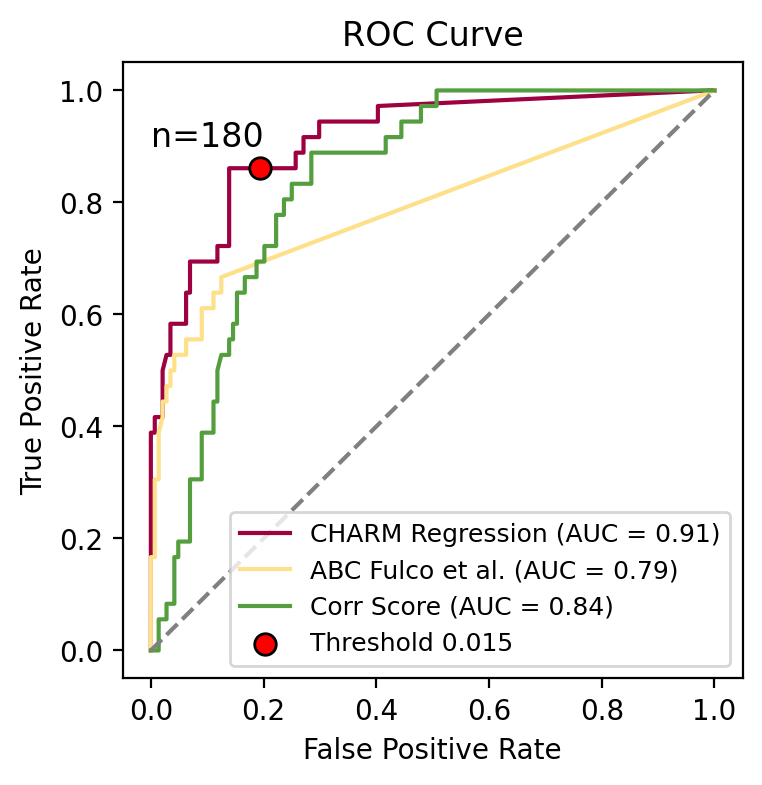

In [27]:
roc_data_temp = roc_data.reset_index(drop=True).copy()

def _calculate_roc_data(true_vec,predict_vec):
    fpr, tpr, _ = roc_curve(true_vec, predict_vec)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

fpr_charm_regression, tpr_charm_regression, roc_auc_charm_regression = _calculate_roc_data(roc_data_temp["label"], roc_data_temp["CHARM_shap"])
fpr_abc_inhouse, tpr_abc_inhouse, roc_auc_abc_inhouse = _calculate_roc_data(roc_data_temp["label"], roc_data_temp["ABC_predict"])
fpr_abc_fulco, tpr_abc_fulco, roc_auc_abc_fulco = _calculate_roc_data(compare_df["label"], compare_df["ABC_score"])
fpr_abc_corscore, tpr_abc_corscore, roc_auc_abc_corscore = _calculate_roc_data(compare_df["label"], compare_df["Corr_score"])

plt.figure(figsize=(4, 4))
plt.plot(fpr_charm_regression, tpr_charm_regression, color="#9e0142",label=f"CHARM Regression (AUC = {roc_auc_charm_regression:.2f})")
plt.plot(fpr_abc_fulco, tpr_abc_fulco, color="#fee08b", label=f"ABC Fulco et al. (AUC = {roc_auc_abc_fulco:.2f})")
plt.plot(fpr_abc_corscore, tpr_abc_corscore, color="#549e3f", label=f"Corr Score (AUC = {roc_auc_abc_corscore:.2f})")


plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.text(0.1, 0.9, f"n={roc_data_temp.shape[0]}", fontsize=12, ha='center')


threshold = 0.015
y_score_charm =  roc_data_temp["CHARM_shap"].values
predicted_positive = y_score_charm >= threshold
actual_positive = roc_data_temp["label"].values == True
actual_negative = roc_data_temp["label"].values == False
tp = np.sum(predicted_positive & actual_positive)
fp = np.sum(predicted_positive & actual_negative)
tpr_at_threshold = tp / np.sum(actual_positive)
fpr_at_threshold = fp / np.sum(actual_negative)

plt.scatter(fpr_at_threshold, tpr_at_threshold, color="red", zorder=5, label=f"Threshold {threshold:.3f}", s=60, edgecolor='black')

plt.legend(loc="lower right", fontsize=9)

# save figure
plt.savefig("figures/roc_curve_comparison.pdf", bbox_inches='tight', dpi=300)

plt.show()


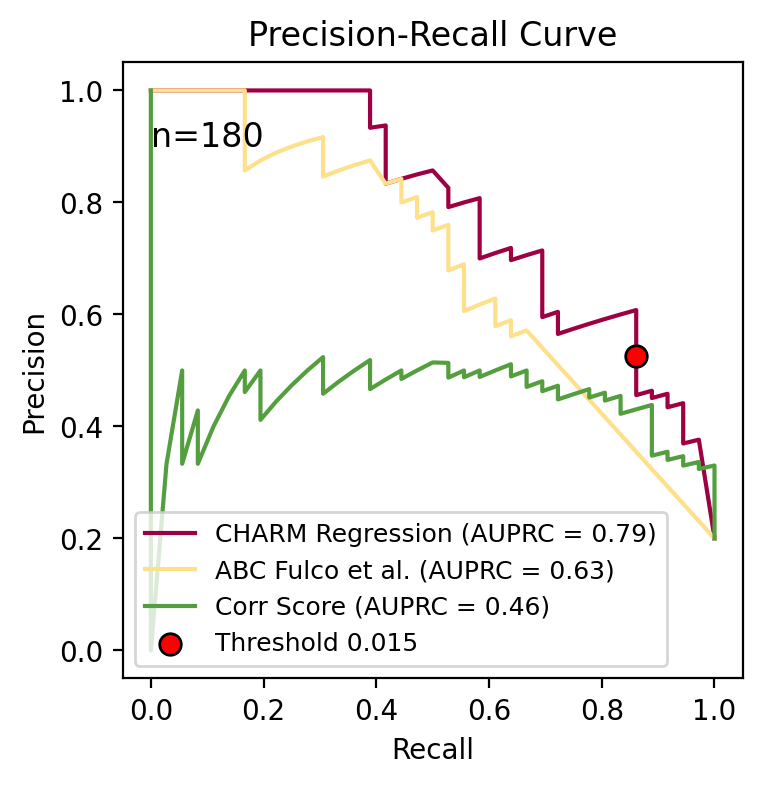

In [28]:
# precion recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def _calculate_precision_recall(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)
    return precision, recall, auprc

precision_charm_regression,recall_charm_regression, auprc_charm_regression = _calculate_precision_recall(roc_data_temp["label"], roc_data_temp["CHARM_shap"])
precision_abc_inhouse, recall_abc_inhouse, auprc_abc_inhouse = _calculate_precision_recall(roc_data_temp["label"], roc_data_temp["ABC_predict"])
precision_abc_fulco, recall_abc_fulco, auprc_abc_fulco = _calculate_precision_recall(compare_df["label"], compare_df["ABC_score"])
precision_abc_corscore, recall_abc_corscore, auprc_abc_corscore = _calculate_precision_recall(compare_df["label"], compare_df["Corr_score"])

plt.figure(figsize=(4, 4))
plt.plot(recall_charm_regression, precision_charm_regression, color="#9e0142", label=f"CHARM Regression (AUPRC = {auprc_charm_regression:.2f})")
plt.plot(recall_abc_fulco, precision_abc_fulco, color="#fee08b", label=f"ABC Fulco et al. (AUPRC = {auprc_abc_fulco:.2f})")
#plt.plot(recall_abc_inhouse, precision_abc_inhouse, color="#fdae61", label=f"ABC In-house (AUPRC = {auprc_abc_inhouse:.2f})")
plt.plot(recall_abc_corscore, precision_abc_corscore, color="#549e3f", label=f"Corr Score (AUPRC = {auprc_abc_corscore:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.text(0.1, 0.9, f"n={roc_data_temp.shape[0]}", fontsize=12, ha='center')

threshold = 0.015

predicted_positive = roc_data_temp["CHARM_shap"].values >= threshold
actual_positive = roc_data_temp["label"].values == True
actual_negative = roc_data_temp["label"].values == False

tp = np.sum(predicted_positive & actual_positive)
fp = np.sum(predicted_positive & actual_negative)
recall_at_threshold = tp / np.sum(actual_positive)
epsilon = 1e-7
precision_at_threshold = tp / (tp + fp + epsilon)
plt.scatter(recall_at_threshold, precision_at_threshold,
            color="red", zorder=5,                   
            label=f"Threshold {threshold:.3f}",s=60,edgecolor='black') 

plt.legend(loc="lower left", fontsize=9)
plt.savefig("figures/prc_curve_comparison.pdf", bbox_inches='tight', dpi=300)


In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(roc_data_temp["label"], roc_data_temp["CHARM_shap"])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold based on F1-score: {optimal_threshold}")


Optimal threshold based on F1-score: 0.019436208816688096
